In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from tensorflow.keras import layers
%matplotlib inline

import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from matplotlib.pyplot import figure
import math
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Prova sul mese di Febbraio 

In [2]:
learning_rate = 0.0005
batch_size = 55
epochs = 30
sequence_length = 168
sequence_prediction = 168

In [3]:
df = pd.read_csv('.\df.csv')

In [4]:
y = df['CO']

scaler = MinMaxScaler()

y_norm = y
y = scaler.fit_transform(y.values.reshape(y.shape[0],1)) 
y_test = y[:-672]

train = y_test[:-1732]
test = y_test[-1732:]

In [5]:
x_train = train[:-sequence_prediction]
y_train = train[sequence_length:]

x_train=x_train.reshape(x_train.shape[0])
y_train=y_train.reshape(x_train.shape[0])

print(x_train.shape, y_train.shape)

(5954,) (5954,)


In [6]:
x_val = test[:-sequence_prediction]
y_val = test[sequence_length:]

x_val= x_val.reshape(x_val.shape[0])
y_val= y_val.reshape(y_val.shape[0])

print(x_val.shape, y_val.shape)

(1564,) (1564,)


In [7]:
def sliding_window_x(elements, window_size):
    array = np.empty([len(elements)-(sequence_length-1), sequence_length])
    if len(elements) <= window_size:
        return elements
    else:
        for i in range(len(elements) - window_size + 1):
            array[i] = elements[i:i+window_size]
        return array

In [8]:
x_train = sliding_window_x(x_train, sequence_length)[:-3]
x_val = sliding_window_x(x_val, sequence_length)[:-1]

x_train = x_train[::sequence_length]
x_val = x_val[::sequence_length]
print(x_train.shape, x_val.shape)

(35, 168) (9, 168)


In [9]:
def sliding_window_y(elements, window_size):
    array = np.empty([len(elements)-(sequence_prediction-1), sequence_prediction])
    if len(elements) <= window_size:
        return elements
    else:
        for i in range(len(elements) - window_size + 1):
            array[i] = elements[i:i+window_size]
        return array

In [10]:
y_train = sliding_window_y(y_train, sequence_prediction)[:-3]
y_val = sliding_window_y(y_val, sequence_prediction)[:-1]

y_train = y_train[::sequence_length]
y_val = y_val[::sequence_length]
print(y_train.shape, y_val.shape)

(35, 168) (9, 168)


In [11]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)

x_val = x_val.reshape(x_val.shape[0],x_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)

print(x_train.shape, y_train.shape)

(35, 168, 1) (35, 168, 1)


In [12]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1), batch_size=1)
lstm_out = keras.layers.LSTM(122, return_sequences=True, stateful = True)(inputs)
dropout_1 =  keras.layers.Dropout(0.5)(lstm_out)
lstm_out_1 = keras.layers.LSTM(66,return_sequences=False, stateful = True)(dropout_1)
dropout_2 =  keras.layers.Dropout(0.5)(lstm_out_1)
outputs = keras.layers.Dense(sequence_prediction)(dropout_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 168, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 168, 122)             60512     
_________________________________________________________________
dropout (Dropout)            (1, 168, 122)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 66)                   49896     
_________________________________________________________________
dropout_1 (Dropout)          (1, 66)                   0         
_________________________________________________________________
dense (Dense)                (1, 168)                  11256     
Total params: 121,664
Trainable params: 121,664
Non-trainable params: 0
_______________________________________________________

In [13]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size = 1,
    validation_data=(x_val,y_val),
    shuffle=False,
    verbose=0,
    callbacks=[es_callback, modelckpt_callback],
)

# 131 batches da 52 osservazioni l'uno 


Epoch 00001: val_loss improved from inf to 0.18893, saving model to model_checkpoint.h5

Epoch 00002: val_loss improved from 0.18893 to 0.14292, saving model to model_checkpoint.h5

Epoch 00003: val_loss improved from 0.14292 to 0.13343, saving model to model_checkpoint.h5

Epoch 00004: val_loss improved from 0.13343 to 0.12817, saving model to model_checkpoint.h5

Epoch 00005: val_loss did not improve from 0.12817

Epoch 00006: val_loss improved from 0.12817 to 0.12531, saving model to model_checkpoint.h5

Epoch 00007: val_loss improved from 0.12531 to 0.12447, saving model to model_checkpoint.h5

Epoch 00008: val_loss improved from 0.12447 to 0.12239, saving model to model_checkpoint.h5

Epoch 00009: val_loss did not improve from 0.12239

Epoch 00010: val_loss did not improve from 0.12239

Epoch 00011: val_loss did not improve from 0.12239

Epoch 00012: val_loss improved from 0.12239 to 0.12213, saving model to model_checkpoint.h5

Epoch 00013: val_loss did not improve from 0.12213


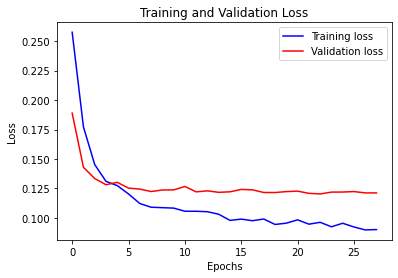

In [14]:
x_plot = list(range(1,es_callback.stopped_epoch+2))

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))

fig = plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
fig.savefig('Train_loss.pdf', format='pdf')

In [15]:
model.load_weights("model_checkpoint.h5")

### Previsioni

In [16]:
x_pred = y_test[-sequence_length:]
x_pred=x_pred.reshape(x_pred.shape[0],1) 
print(x_pred.shape)

(168, 1)


In [17]:
 for i in range(1,5):
        
    x_pred_int = x_pred[-sequence_length:].reshape(1,sequence_length,1) 
    predictions = model.predict(x_pred_int, batch_size = 1)
    x_pred = np.append(x_pred, predictions.reshape(predictions.shape[1],1), axis=0)
    

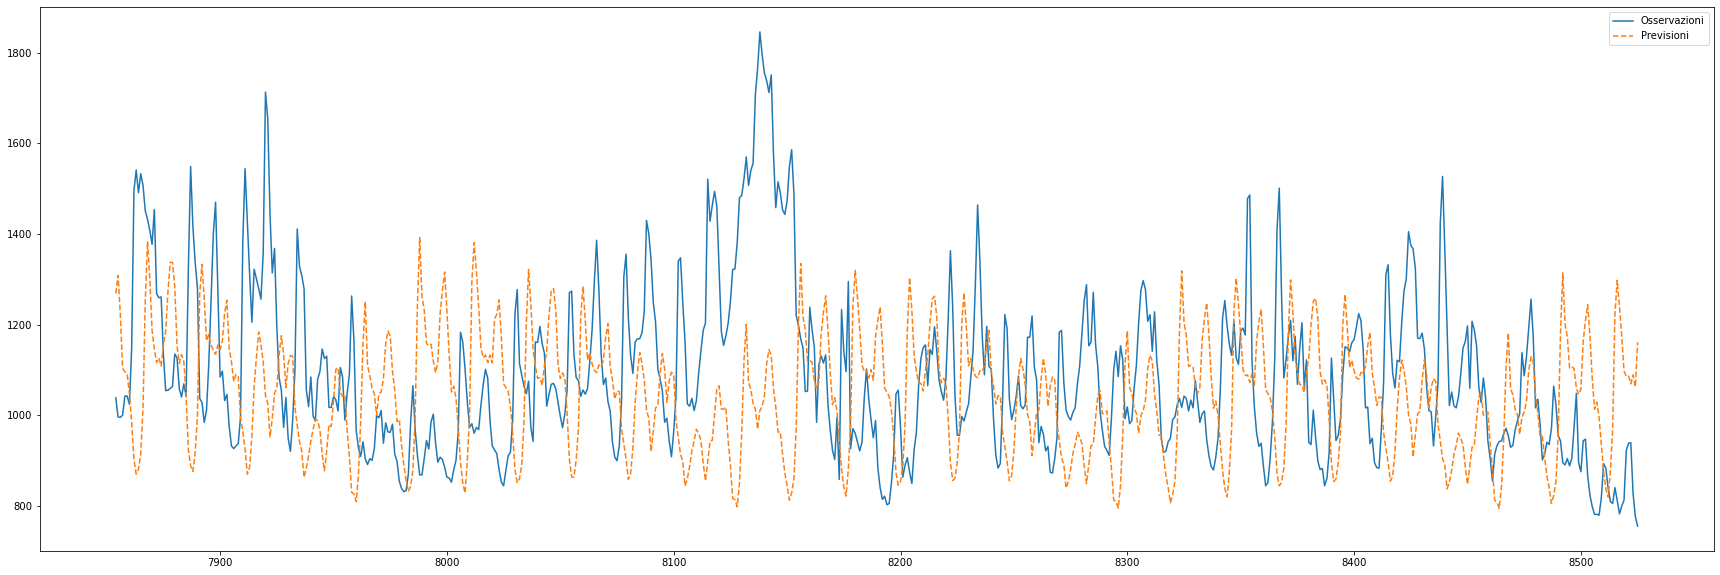

In [18]:
previsioni = scaler.inverse_transform(x_pred)
previsioni = previsioni[sequence_length:]
originali = y_norm[-672:]

fig = plt.figure(figsize=(30, 10))
plt.plot(range(7854, 8526),originali, label="Osservazioni")
plt.plot(range(7854, 8526),previsioni,'--',  label="Previsioni")
plt.legend()

fig.savefig('Pred_vs_Orig_zoom.pdf', format='pdf')

In [19]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(originali, previsioni.flatten())/ originali))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 17.52 %


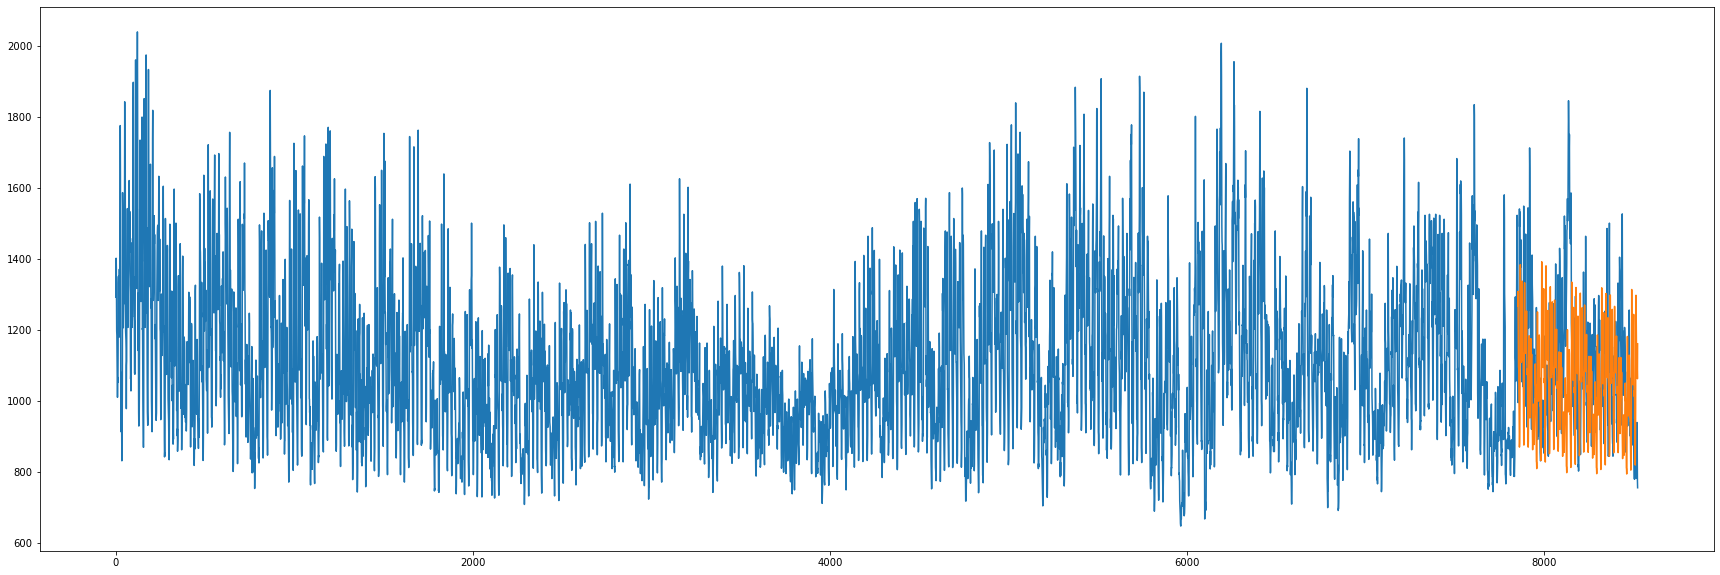

In [20]:
fig = plt.figure(figsize=(30, 10))
plt.plot(df['CO'])
plt.plot(range(7854, 8526),previsioni)

fig.savefig('Pred_vs_Orig.pdf', format='pdf')

## Previsioni ultimo mese

In [21]:
x_pred = y[-sequence_length:]#.values
x_pred=x_pred.reshape(x_pred.shape[0],1) 
print(x_pred.shape)

(168, 1)


In [22]:
 for i in range(1,6): #4 per 168 #3 per 366
        
    x_pred_int = x_pred[-sequence_length:].reshape(1,sequence_length,1)  
    predictions = model.predict(x_pred_int, batch_size = 1)
    x_pred = np.append(x_pred, predictions.reshape(predictions.shape[1],1), axis=0)
    

In [23]:
previsioni = scaler.inverse_transform(x_pred)
previsioni = previsioni[sequence_length:]
previsioni = previsioni[:-96]

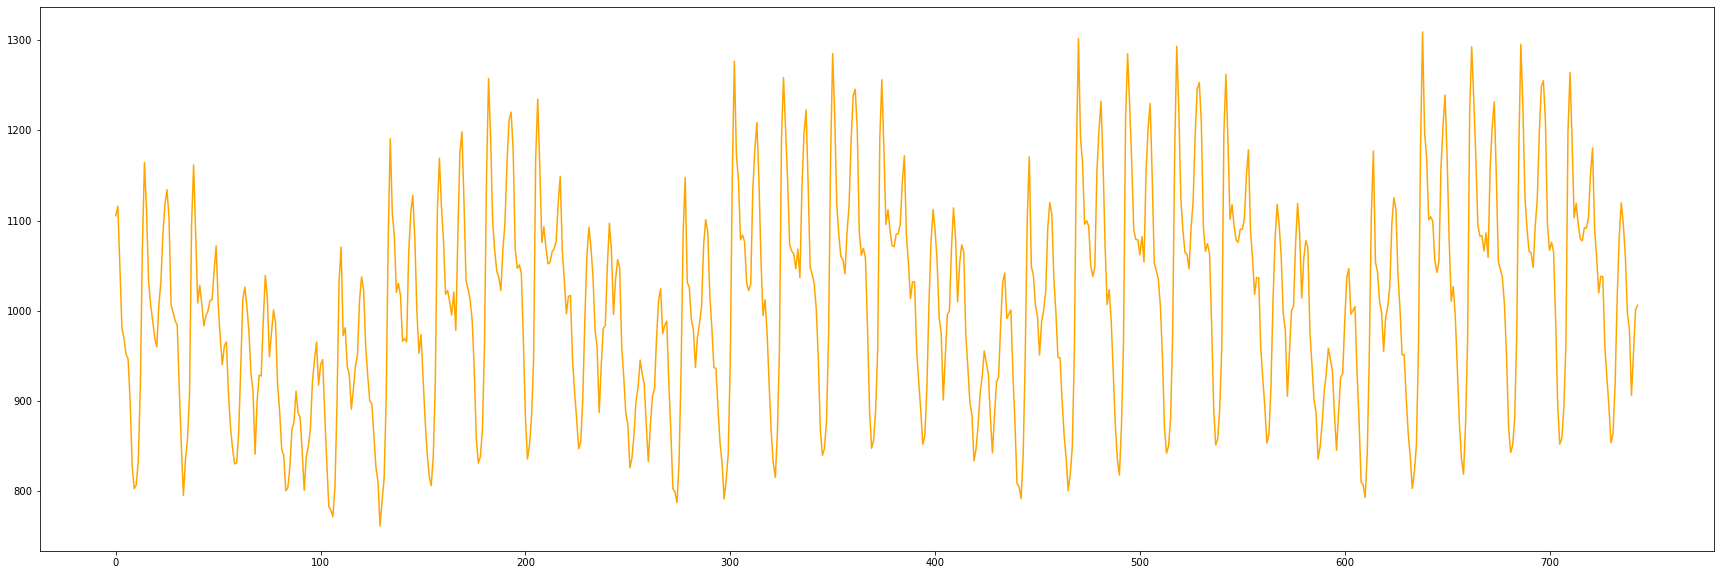

In [24]:
fig = plt.figure(figsize=(30, 10))
plt.plot(previsioni,  label="Previsioni", color='orange')

fig.savefig('Predictions.pdf', format='pdf')

<Figure size 2400x800 with 0 Axes>

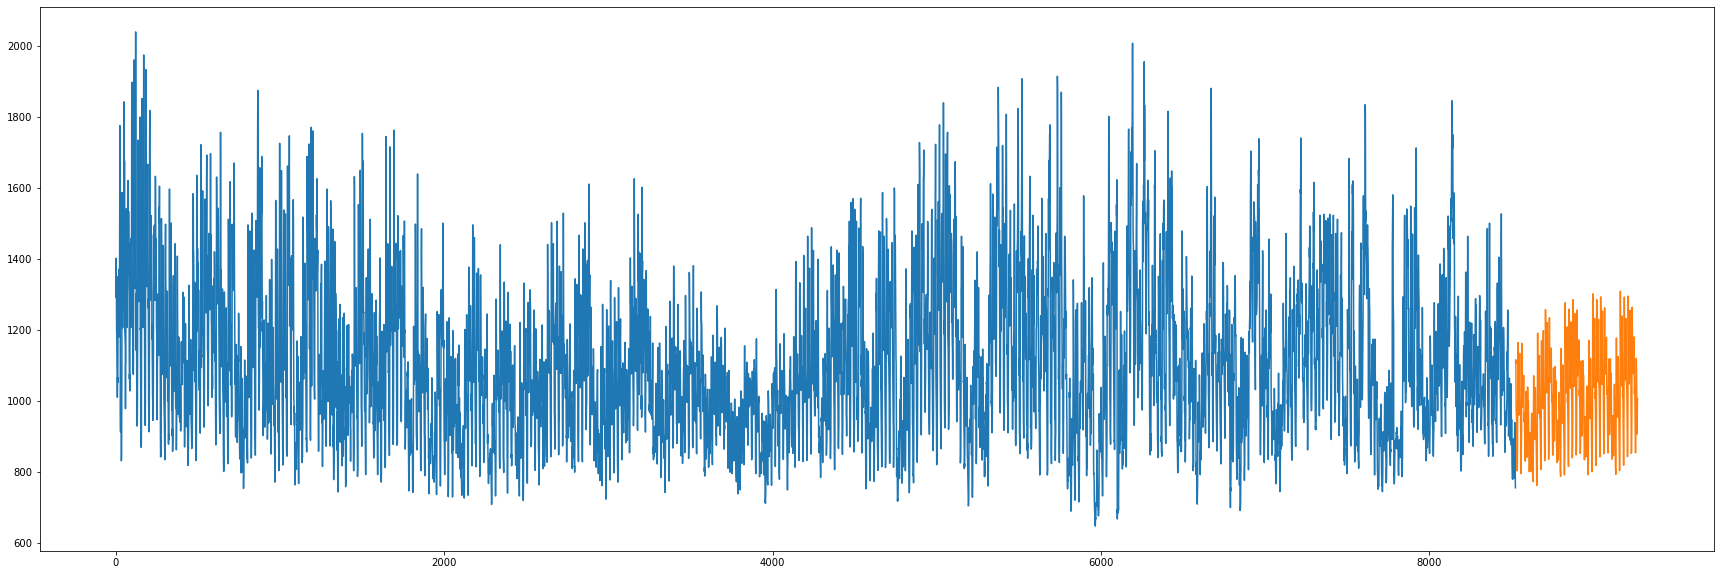

In [25]:
figure(figsize=(30, 10), dpi=80)

fig = plt.figure(figsize=(30, 10))
plt.plot(df['CO'])
plt.plot(range(8526, 9270),previsioni)
fig.savefig('Pred_on_model.pdf', format='pdf')

In [26]:
df_previsioni = pd.read_csv(".\866654_20220613.csv")

previsioni = previsioni.reshape(previsioni.shape[0])
df_previsioni['ML'] = previsioni

In [110]:
df_previsioni.to_csv(".\866654_20220613.csv", sep=',')